***IMPORTING LIBRARIES AND DATA***

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import fmin, tpe, hp, Trials
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

***DATA PREPROCESSING***

In [62]:
def preprocess_data(data, target_column):
    data = data.dropna()

    for column in data.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])

    X = data.drop(columns=[target_column])
    y = data[target_column]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(X, y, test_size=0.2, random_state=42)


data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
X_train, X_test, y_train, y_test = preprocess_data(df, 'target')


***Bayesian Optimization with Gaussian Process Regression (GPR)***

In [63]:
def objective_function_gpr(params, X_train, y_train, model_type):
    params = params.flatten()
    if model_type == 'random_forest':
        param_dict = {
            'n_estimators': int(params[0]),
            'max_depth': int(params[1]),
            'min_samples_split': int(params[2])
        }
        model = RandomForestClassifier(**param_dict)
    elif model_type == 'svc':
        param_dict = {
            'C': params[0],
            'gamma': params[1]
        }
        model = SVC(**param_dict, probability=True)
    elif model_type == 'logistic_regression':
        param_dict = {
            'C': params[0]
        }
        model = LogisticRegression(**param_dict, max_iter=1000)
    else:
        raise ValueError(f"Model '{model_type}' is not supported.")

    roc_auc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc'))
    return -roc_auc  # We minimize negative AUC

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = bounds.shape[0]
    min_val = 1
    min_x = None

    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000})
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(1, -1)


def bayesian_optimization_gpr(objective_function, bounds, X_train, y_train, model_type, n_iter=100):
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(5, bounds.shape[0]))
    Y_sample = np.array([objective_function(x, X_train, y_train, model_type) for x in X_sample])

    kernel = Matern(nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10, optimizer=None)

    param_history = []
    score_history = []
    for i in range(n_iter):
        gpr.fit(X_sample, Y_sample)
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
        Y_next = objective_function(X_next, X_train, y_train, model_type)
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)

        # Track parameter values and scores over iterations
        param_history.append(X_next.flatten())
        score_history.append(-Y_next)  # store the positive AUC score

        if (i + 1) % 25 == 0:
            print(f"Iteration {i + 1}/{n_iter}: ROC AUC: {max(score_history):.4f}")

    best_params = X_sample[np.argmin(Y_sample)]
    best_score = np.min(Y_sample)

    return best_params, best_score, np.array(param_history), score_history


***Hyperopt Optimization***

In [64]:
def objective_function_hyperopt(params, X_train, y_train):
    model_type = 'random_forest'  # Adjust based on the model being optimized
    params = {k: v[0] if isinstance(v, list) else v for k, v in params.items()}  # Unpack nested dicts/lists
    if model_type == 'random_forest':
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        model = RandomForestClassifier(**params)
    elif model_type == 'svc':
        model = SVC(**params, probability=True)
    elif model_type == 'logistic_regression':
        model = LogisticRegression(**params, max_iter=1000)
    else:
        raise ValueError(f"Model '{model_type}' is not supported.")

    roc_auc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc'))
    return -roc_auc  # We minimize negative AUC

def get_hyperopt_space(model_type):
    if model_type == 'random_forest':
        space = {
            'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
            'max_depth': hp.quniform('max_depth', 1, 20, 1),
            'min_samples_split': hp.uniform('min_samples_split', 2, 10)
        }
    elif model_type == 'svc':
        space = {
            'C': hp.loguniform('C', np.log(0.01), np.log(100)),
            'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(1))
        }
    elif model_type == 'logistic_regression':
        space = {
            'C': hp.loguniform('C', np.log(0.01), np.log(100))
        }
    else:
        raise ValueError(f"Model '{model_type}' is not supported.")

    return space


def hyperopt_optimization(objective_function, space, X_train, y_train, max_evals=50):
    trials = Trials()
    best_params = fmin(fn=lambda params: objective_function(params, X_train, y_train), space=space,
                       algo=tpe.suggest, max_evals=max_evals, trials=trials)

    score_history = [-trial['result']['loss'] for trial in trials.trials]
    param_history = [trial['misc']['vals'] for trial in trials.trials]

    return best_params, score_history, param_history


***RANDOM SEARCH OPTIMIZATION***

In [65]:
def random_search_optimization(param_distributions, X_train, y_train, n_iter=50):
    random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_distributions,
                                       n_iter=n_iter, cv=5, scoring='roc_auc', random_state=42)
    random_search.fit(X_train, y_train)

    random_search_scores = random_search.cv_results_['mean_test_score']
    random_search_params = random_search.cv_results_['params']

    return random_search_scores, random_search_params


***EVALUATE AND TRAINING AND RESULTS***

In [66]:
def evaluate(score_history, param_history):
    best_score = max(score_history)
    best_iteration = score_history.index(best_score)
    best_params = param_history[best_iteration]
    return best_score, best_iteration, best_params


bounds = np.array([[10, 100], [1, 20], [2, 10]])  # Define bounds for each parameter
best_params_gpr, best_score_gpr, param_history_gpr, score_history_gpr = bayesian_optimization_gpr(
    objective_function_gpr, bounds, X_train, y_train, 'random_forest', n_iter=50)


space_hyperopt = get_hyperopt_space('random_forest')


best_params_hyperopt, score_history_hyperopt, param_history_hyperopt = hyperopt_optimization(
    objective_function_hyperopt, space_hyperopt, X_train, y_train, max_evals=50)


param_distributions = {
    'n_estimators': np.arange(10, 110, 10),
    'max_depth': np.arange(1, 21),
    'min_samples_split': np.arange(2, 11)
}


random_search_scores, random_search_params = random_search_optimization(param_distributions, X_train, y_train)


best_score_gpr, best_iteration_gpr, best_params_gpr = evaluate(score_history_gpr, param_history_gpr)
best_score_hyperopt, best_iteration_hyperopt, best_params_hyperopt = evaluate(score_history_hyperopt, param_history_hyperopt)
best_score_random_search = max(random_search_scores)

print(f"Best cross validationn GPR score: {best_score_gpr} at iteration {best_iteration_gpr} with parameters {best_params_gpr}")
print(f"Best cross validation Hyperopt score: {best_score_hyperopt} at iteration {best_iteration_hyperopt} with parameters {best_params_hyperopt}")
print(f"Best cross validation Random Search score: {best_score_random_search} with parameters {random_search_params[np.argmax(random_search_scores)]}")


Iteration 25/50: ROC AUC: 0.9906
Iteration 50/50: ROC AUC: 0.9906
100%|██████████| 50/50 [00:30<00:00,  1.62trial/s, best loss: -0.990038691602693]
Best cross validationn GPR score: 0.9905959347936502 at iteration 14 with parameters [83.83257714 18.64374992  6.54825155]
Best cross validation Hyperopt score: 0.990038691602693 at iteration 27 with parameters {'max_depth': [13.0], 'min_samples_split': [6.331922746376195], 'n_estimators': [27.0]}
Best cross validation Random Search score: 0.9910203777930905 with parameters {'n_estimators': 90, 'min_samples_split': 10, 'max_depth': 15}


***FUNCTIONS TO PLOT SOME CURVES REGARDING RESULT***

In [69]:
# Function to plot ROC AUC scores vs iteration for each method
def plot_scores_vs_iteration(score_history_gpr, score_history_hyperopt, random_search_scores):
    iterations = range(1, len(score_history_gpr) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(iterations, score_history_gpr, marker='o', linestyle='-', color='b', label='GPR')
    plt.plot(iterations, score_history_hyperopt, marker='o', linestyle='-', color='g', label='Hyperopt')
    plt.plot(iterations, random_search_scores, marker='o', linestyle='-', color='r', label='Random Search')

    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC Score')
    plt.title('ROC AUC Score vs Iteration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot learning curves for GPR
def plot_learning_curves(score_history_gpr, param_history_gpr):
    iterations = range(1, len(score_history_gpr) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(iterations, score_history_gpr, marker='o', linestyle='-', color='b')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC Score')
    plt.title('Learning Curves for GPR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot comparison of ROC AUC score distributions
def plot_comparison(scores_gpr, scores_hyperopt, scores_random_search):
    methods = ['GPR', 'Hyperopt', 'Random Search']
    scores = [scores_gpr, scores_hyperopt, scores_random_search]

    plt.figure(figsize=(10, 6))
    for i, method in enumerate(methods):
        plt.hist(scores[i], bins=20, alpha=0.7, label=method, density=True)

    plt.xlabel('ROC AUC Score')
    plt.ylabel('Density')
    plt.title('Distribution of ROC AUC Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to plot Hyperparameter Convergence
def plot_hyperparameter_convergence(param_history, param_names):
    num_params = len(param_names)
    iterations = range(1, len(param_history) + 1)

    plt.figure(figsize=(12, 8))

    for i in range(num_params):
        param_values = [params[i] for params in param_history]
        plt.plot(iterations, param_values, marker='o', linestyle='-', label=param_names[i])

    plt.xlabel('Iteration')
    plt.ylabel('Hyperparameter Value')
    plt.title('Hyperparameter Convergence Plot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

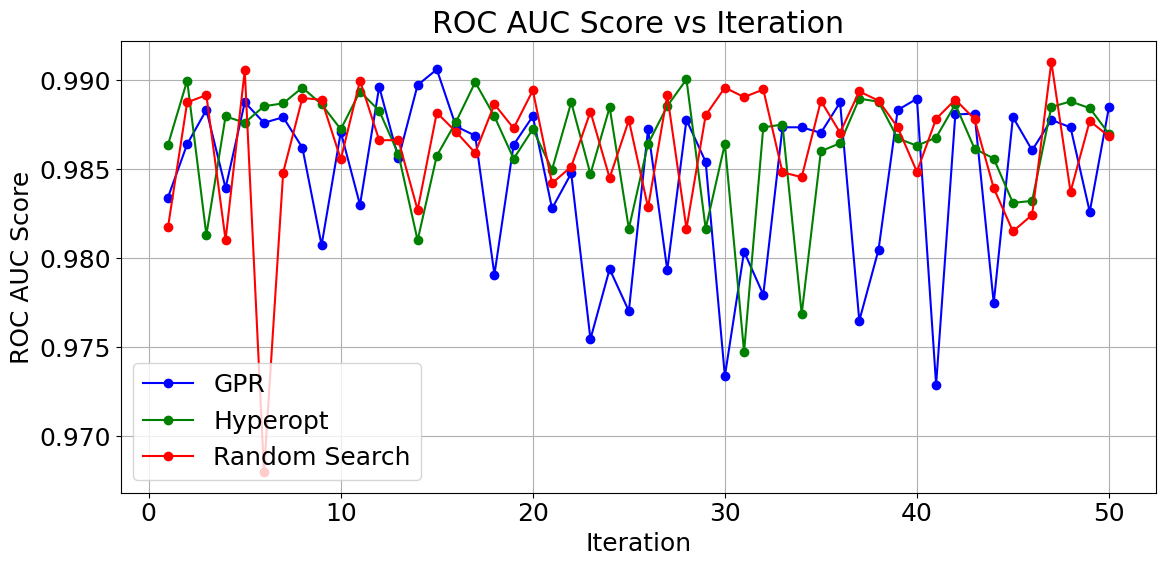

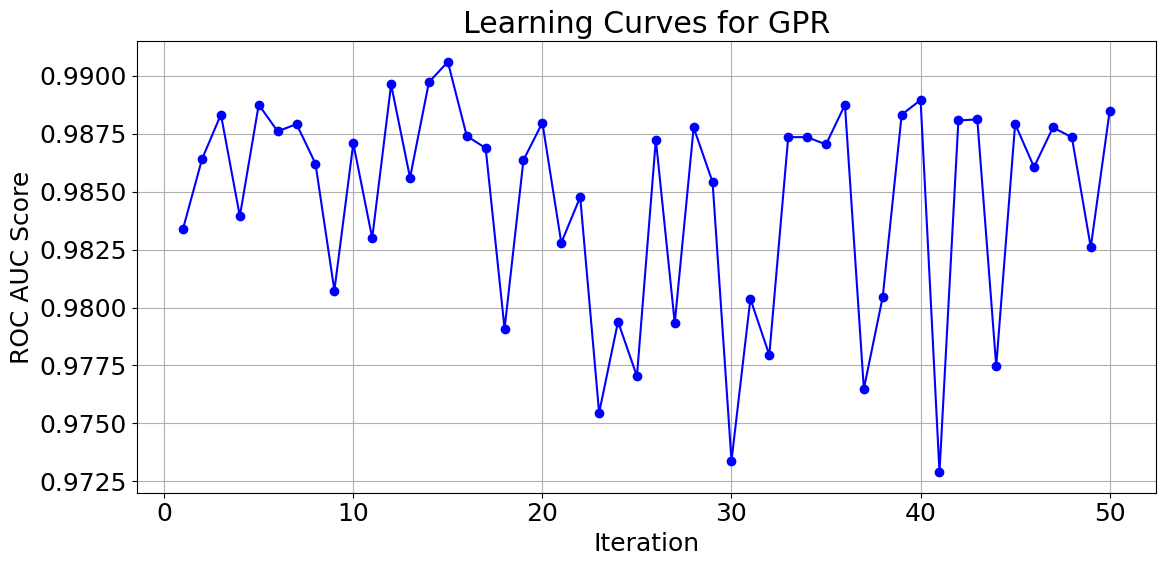

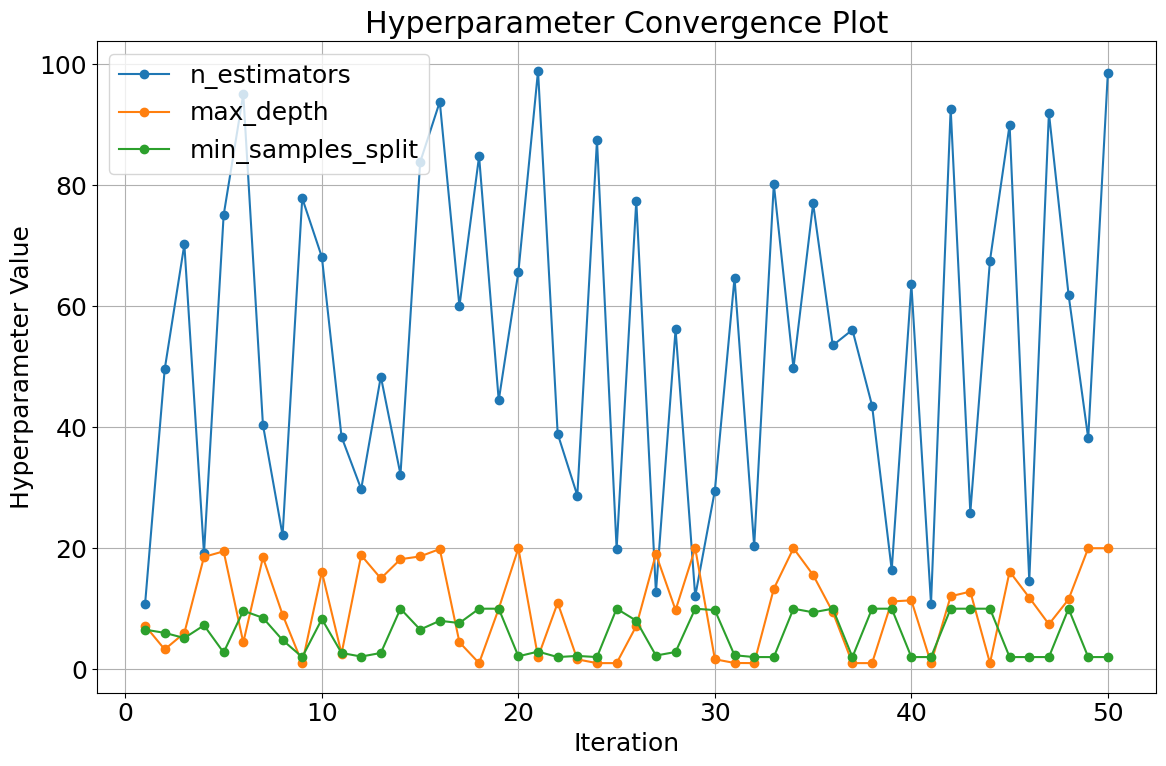

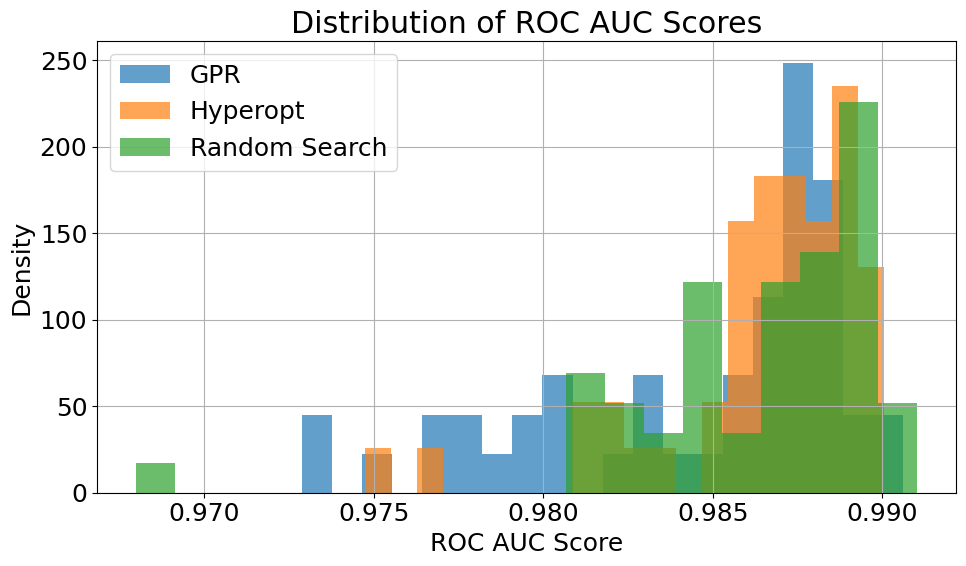

In [70]:
plot_scores_vs_iteration(score_history_gpr, score_history_hyperopt, random_search_scores)

plot_learning_curves(score_history_gpr, param_history_gpr)

param_names = ['n_estimators', 'max_depth', 'min_samples_split']

plot_hyperparameter_convergence(param_history_gpr, param_names)

plot_comparison(score_history_gpr, score_history_hyperopt, random_search_scores)